# 12 | Collaborative Coding: Two-view Structure from Motion
**ES143 Computer Vision, Harvard University, Fall 2020**

This is an independent coding task with open collaboration. That means you will edit and submit your own notebook, but can openly share ideas, strategies, and snippets of code with your breakout roomates.

In this task you will learn to:
1. Compute an essential matrix from a fundamental matrix when the calibration matrix ${\bf K}$ is known.
2. Compute four candidate camera-pairs ${\bf P},{\bf P}'$, with each pair being consistent with the essential matrix.
3. Triangulate a 3D point ${\bf X}=(X,Y,Z)$ from corresponding image points ${\bf x}\leftrightarrow{\bf x}'$ and cameras ${\bf P},{\bf P}'$.
4. Use triangulation and visualization to identify the correct pair ${\bf P},{\bf P}'$ from the four candidates.

We provide you with code for items 1, 2, and 4. You must write your own code for Item 3 based on HZ Section 12.2. 

This notebook requires datafile `playroom_es143_small.zip`, which is available on the course website.

---

## Instructions

1. Run the notebook.
2. Edit the notebook according to the instructions in the cell marked *WORK HERE*. Post a snapshot of your results to [padlet](https://padlet.com/zickler/twoviews) as instructed.
3. If you complete Step 2 and have time to spare, pursue one of the enrichment opportunities at the bottom of this notebook.
4. Before the end of the Class Session, submit .ipynb and .html versions of this notebook to [canvas](https://canvas.harvard.edu/courses/78234/assignments/426300). Submission filenames should be of the form twoviews_lastname_firstname.ipynb and twoviews_lastname_firstname.html.


#### Required packages

In [7]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
#from pupil_apriltags import Detector
import requests
import pickle
import glob   # filename and path management for file I/O

import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

#### Required data files

In [2]:
# Unzip the required datafile if necessary
! unzip -n ./playroom_lowres.zip

# Pickle file with intrinsic calibration: calMatrix ($K$) and distCoeffs
CALIBFILE = './playroom_lowres/playroom_es143_small_calib.pickle'

# Pickle file with AprilBoard geometry: at_finboard and at_coareboard
BOARDFILE = './playroom_lowres/AprilBoards.pickle'

# Two particular images from the playroom dataset for this notebook
LEFTIMAGE = './playroom_lowres/playroom_es143_small_00003.JPG'
RIGHTIMAGE = './playroom_lowres/playroom_es143_small_00004.JPG'


Archive:  ./playroom_lowres.zip


## Familiar helper functions

* `in2hom(X)`: Convert $N\times m$ inhomogeneous to $N\times (m+1)$ homogeneous coordinates for $N>1$
* `hom2him(X)`: Convert $N\times m$ homogeneous to $N\times (m-1)$ inhomogeneous coordinates for $N>1$
* `plotimageline(h,w,line,ax)`: Add line to matplotlib figure
* `plotcamera(h,w,camera,raysize,figobj)`: Add tetrahedral camera to pyplot figure

In [8]:
# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

def plotimageline(h,w,line,ax):
# Add image line to matplotlib figure
# Input:
#   h,w -- height and width of image (in pixels)
#   l  -- 3-vector of line coordinates (a,b,c)
#   ax -- plt.axes object 
#
# Returns: 1

    x,y=np.meshgrid(np.linspace(0,w,w*2),np.linspace(0,h,h*2))
    ax.contour(x, y, line[0]*x+line[1]*y+line[2], [0], colors='r')

    return 1

def plotcamera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# Input:
#   h,w --     height and width of image in pixels
#   camera --  3x4 camera matrix
#   raysize -- length of tetrahedral edges (in world units)
#   fig --     pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector 
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])
    
    # Compute camera center (null vector of P)
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left 
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right
    
    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3], 
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1), 
        rcond=None)[0])
    
    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)
    
    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)
    
    #   desired ray segments that are length raysize in these directions 
    V = np.tile(C, (4, 1)) + raysize * V
    
    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]], 
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))
   
    return 1

## Load images and data

In [9]:
# Read images, convert to RGB
im1 = cv2.imread(LEFTIMAGE)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread(RIGHTIMAGE)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

# import calibration data
data = pickle.load(open(CALIBFILE, 'rb'))
calMatrix = data['calMatrix']                # K matrix
distCoeffs = data['distCoeffs']              # distortion coefficients

# import AprilBoard data
data = pickle.load(open(BOARDFILE, 'rb'))
at_coarseboard = data['at_coarseboard']
at_fineboard = data['at_fineboard']

## Detect and match SIFT features

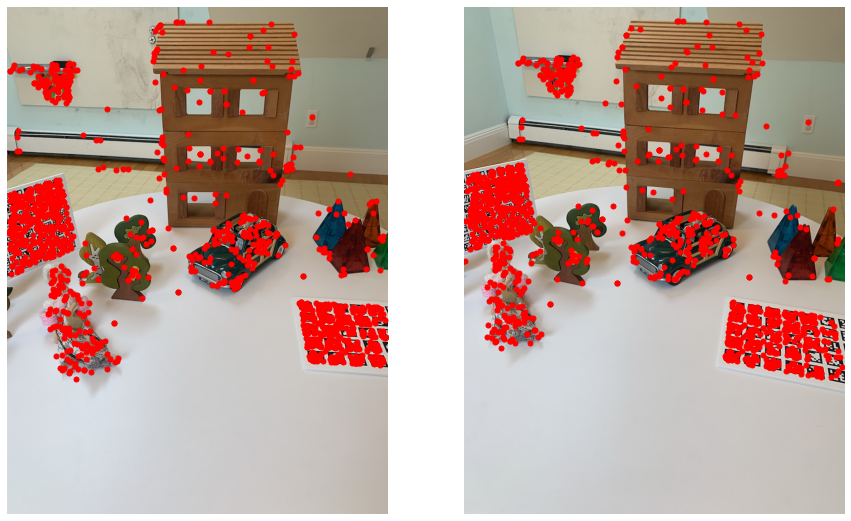

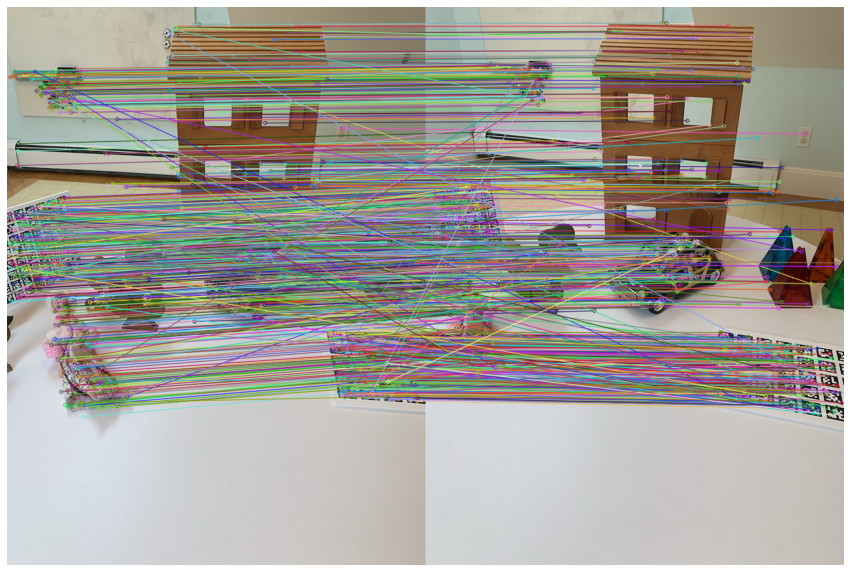

In [10]:
GOOD_MATCH_PERCENT=1   # top % of matches to keep between two images

# Create a SIFT object
sift = cv2.SIFT_create()

# Get SIFT keypoints and descriptors for each image
kp1, des1 = sift.detectAndCompute(cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY), None)
kp2, des2 = sift.detectAndCompute(cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY), None)

# Create a "brute force" matcher object using the L2 norm,
#  and using "cross check" to only keep symmetric matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Find matches between images 1->2 and images 3->2
# Notes:
#   - The output is a list of openCV "Dmatch" objects, which are described here:
#     https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
#   - Each entry of the output list represents a match between the input 
#     descriptor-sets and includes these three attributes 
#         matches12[i].distance - Distance between matched descriptors. The lower, the better it is.
#         matches12[i].queryIdx - Index of descriptor in first set (des1 or des3 here)
#         matches12[i].trainIdx - Index of descriptor in second set (des2 here)
#     (OpenCV's use of the names "train" and "query" here is particulary unintuitive.)
matches12 = bf.match(des1, des2)

# Sort matches in the order of increasing match-distance; keep top ones
matches12 = sorted(matches12, key = lambda x:x.distance)
numGoodMatches = int(len(matches12) * GOOD_MATCH_PERCENT)
matches12 = matches12[:numGoodMatches]

# Get pixel coordinates of the surving matches
X1 = np.array([kp1[match.queryIdx].pt for match in matches12])
X2 = np.array([kp2[match.trainIdx].pt for match in matches12])

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1[:, 0], X1[:, 1], '.r', markersize=10)
ax1.axis('off')
ax2.imshow(im2)
ax2.plot(X2[:, 0], X2[:, 1], '.r', markersize=10)
ax2.axis('off')

# Draw matches
imMatches = cv2.drawMatches(im1,kp1,im2,kp2,matches12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.subplots(figsize=(15,15))
plt.imshow(imMatches)
plt.axis('off')
plt.show()


## Find fundamental matrix and good matches using RANSAC

Relevant OpenCV documentation: [cv2.findFundamentalMat()](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a)


Number of matches that are good: 344 of 1249
Fundamental Matrix:
 [[-5.49751994e-08 -1.94720630e-05 -2.65288686e-03]
 [ 8.09824540e-06 -6.74870610e-07  7.51194471e-02]
 [ 9.29132813e-04 -6.93215567e-02  1.00000000e+00]]


(-0.5, 749.5, 999.5, -0.5)

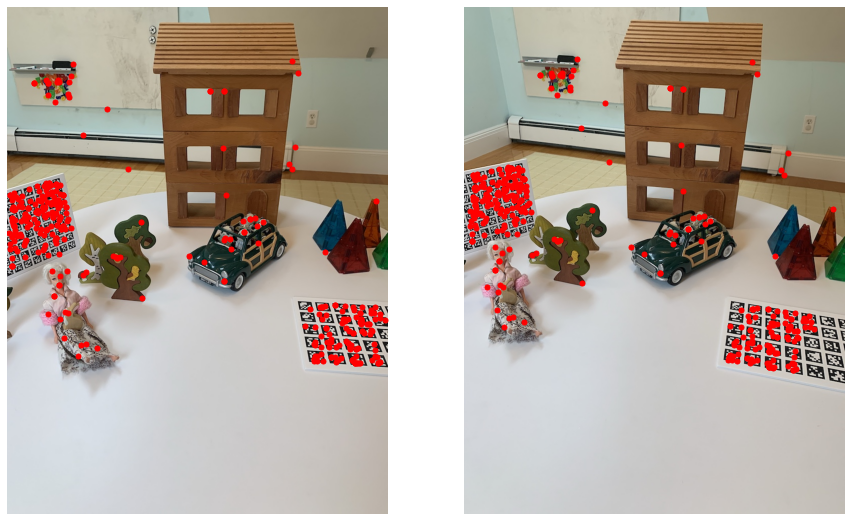

In [25]:
# compute fundamental matrix
F, mask = cv2.findFundamentalMat(X1,X2,cv2.FM_RANSAC,0.1) 
# 0.2 is the inlier pixel distance between the correspoinding point x' and the l' that it should lie on.
# The x' has to lie within 0.2 pixel distance from the l' for it to be called the inlier.
# we are being strict because there are so many detected candidates

# Subset of points that are inliers
X1in = X1[mask.ravel()==1] # 
X2in = X2[mask.ravel()==1]

print('Number of matches that are good: {} of {}'.format(X1in.shape[0],X1.shape[0]))
print('Fundamental Matrix:\n', F)

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1in[:, 0], X1in[:, 1], '.r', markersize=10)
ax1.axis('off')
ax2.imshow(im2)
ax2.plot(X2in[:, 0], X2in[:, 1], '.r', markersize=10)
ax2.axis('off')

## Visualize epipolar geometry

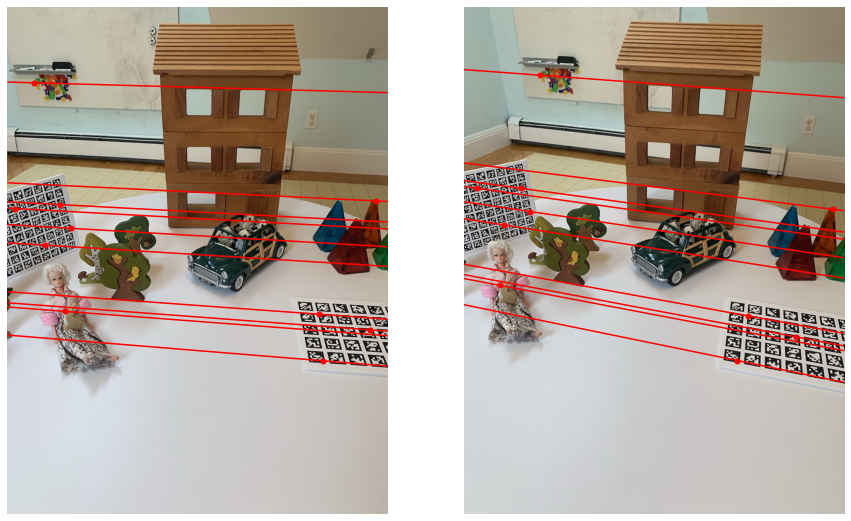

In [26]:
# Retrieve image dimensions (for later use in plotting)
h,w,_=im2.shape

# Total number of point matches
numMatches = X1in.shape[0]

# Epipolar lines
L2 = in2hom(X1in).dot(F.transpose())
L1 = in2hom(X2in).dot(F)

# Randomly choose NUMTOPLOT pooint-matches to visualize
NUMTOPLOT = 10
ind = np.random.choice(np.arange(X1in.shape[0]), 
                       size=NUMTOPLOT, 
                       replace=False)

# Plot points overlaid on images
_, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(im1)
ax1.plot(X1in[ind, 0], X1in[ind, 1], '.r', markersize=10)
ax1.axis('off')

ax2.imshow(im2)
ax2.plot(X2in[ind, 0], X2in[ind, 1], '.r', markersize=10)
ax2.axis('off')

# Plot corresponding epipolar lines
for i in ind:
    plotimageline(h,w,L1[i,:],ax1)
    plotimageline(h,w,L2[i,:],ax2)

## Compute camera-pairs ${\bf P},{\bf P}'$ from essential matrix

The fundamenal matrix ${\bf F}$ (variable `F`) together with the intrinsic calibration matrix ${\bf K}$ (variable `calMatrix`) determine an essential matrix using ${\bf E}={\bf K}^\top{\bf F}{\bf K}$. This essential matrix determines the relative pose of the two cameras (and thus the two camera matrices) up to a four-way choice.

The next cell defines a function, `extractCameras()`, that computes four candidate camera-pairs ${\bf P},{\bf P}'$, with each pair being consistent with the essential matrix. It uses HZ Result 9.19 (page 259).


In [27]:
# Compute pairs of cameras that are consistent with an essential matrix
def extractCameras(E, calMatrix):
# Usage: P1,P2 = extract Cameras(E, calMatrix)
#
# Input:
#   E         -- 3x3 essential matrix
#   calMatrix -- 3x3 upper-traignular camera calibration matrix K
#
# Returns:
#   P1 -- 3x4 camera matrix of first camera: P1 = K[I | 0]
#   P2 -- 3x4x4 array with each P2[:,:,i] a 3x4 matrix of second camera: P2 = K[Ri | ti] 

    # Matrices defined in HZ Equation (9.13)
    W = np.array([[0,-1,0],
                  [1,0,0],
                  [0,0,1]])
    Z = np.array([[0,1,0],
                  [-1,0,0],
                  [0,0,0]])

    # SVD of essential matrix
    U,D,VT = np.linalg.svd(E)

    # first camera
    P1 = calMatrix @ np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    
    # four candidates for second camera (HZ Results 9.19 (page 259))
    P2 = np.zeros((3,4,4))
    P2[:,:,0] = calMatrix @ np.hstack((U @ W @ VT, np.expand_dims(U[:,-1],axis=1)))
    P2[:,:,1] = calMatrix @ np.hstack((U @ W @ VT, -np.expand_dims(U[:,-1],axis=1)))
    P2[:,:,2] = calMatrix @ np.hstack((U @ W.T @ VT, np.expand_dims(U[:,-1],axis=1)))
    P2[:,:,3] = calMatrix @ np.hstack((U @ W.T @ VT, -np.expand_dims(U[:,-1],axis=1)))

    return P1,P2


## Triangulate and visualize points (WORK HERE)

The following cell contains skeleton code for you to complete. Once completed, the cell will allow you to accomplish the two structure-from-motion steps that remain:
* Triangulate 3D points ${\bf X}=(X,Y,Z)$ from corresponding image points ${\bf x}\leftrightarrow{\bf x}'$ and cameras ${\bf P},{\bf P}'$.
* Use triangulation and visualization to identify the correct pair ${\bf P},{\bf P}'$ from the four candidates.

### Instructions:
1. Edit the code on line 15 to complete the definition of function `triangulate()`. This function should compute a 3D point ${\bf X}$ from corresponding image points ${\bf x}\leftrightarrow{\bf x}'$ and cameras ${\bf P},{\bf P}'$ using the "Homogeneous method (DLT)" described in HZ Section 12.2 (page 312).
2. Edit line 25 to specify a manual selection of one of the four choices for the second camera matrix, `P2[:,:,i]`, for $i=0,1,2$ or $3$.
3. Run the cell and carefully inspect the resulting plot from different angles.
4. Repeat Steps 2 and 3 until you identify the correct choice for the second camera. Post an attractive snapshot of your results to [padlet](https://padlet.com/zickler/twoviews), adjusting the plotly figure if needed. Be sure to include your name in the title of your post.

In [28]:
def triangulate(x1, x2, P1, P2):
# Triangulate a 3D point from corresponding image points in two views
#
# Usage: P1,P2 = extract Cameras(E, calMatrix)
#
# Input:
#   x1 -- single 2D point (x,y) in first image
#   x2 -- single 2D point (x,y) in second image
#   P1 -- 3x4 camera matrix for first camera 
#   P2 -- 3x4 camera matrix for second camera 
#
#  Returns:
#   X -- 3D point (x,y,z)
    # Fix below
    A = np.array([
        x1[0] * P1[2].T - P1[0].T,
        x1[1] * P1[2].T - P1[1].T,
        x2[0] * P2[2].T - P2[0].T,
        x2[1] * P2[2].T - P2[1].T
    ])
    
    U, D, VT = np.linalg.svd(A)
    
    X = VT[-1,]
#     print(X)
    X = X.reshape(1,-1)
    return hom2in(X)

# Compute essential matrix and candidate camera-pairs
E = calMatrix.T @ F @ calMatrix 
P1, P2 = extractCameras(E, calMatrix)

# Edit this line to manually select one of the four candidates 
#   for Camera 2: P2[:,:,0], P2[:,:,1], P2[:,:,2], or P2[:,:,3]  
P2test = P2[:,:,1]

# triangulate X1in and X2in to obtain 3D points using P1 and candidate P2
numpts = X1in.shape[0]
X = np.zeros((numpts,3))
for iters in range(X1in.shape[0]):
    X[iters, :] = triangulate(X1in[iters, :], X2in[iters, :], P1, P2test)

# create plotly figure
fig = go.Figure()

# add triangulated 3D points
fig.add_trace(go.Scatter3d(x=X[:,0], 
                           y=X[:,1],
                           z=X[:,2],
                           mode='markers',
                           marker=dict(
                               size=2,
                               color='#1f77b4'
                           )
                          ))

# add cameras
plotcamera(h,w,P1,1,fig)
plotcamera(h,w,P2test,1,fig)

# adjust plotly figure: aspect ratio and initial viewing direction
fig.update_layout(scene_aspectmode='manual',
                  scene_aspectratio=dict(x=1, y=1, z=1),
                  showlegend=False,
                  scene_camera=dict(
                      up=dict(x=0, y=-1, z=0),
                      center=dict(x=0, y=0, z=0),
                      eye=dict(x=0, y=-.5, z=-2)
                  )
                  )
fig.show()

## Extension and Enrichment Opportunities (WORK HERE)

If you complete the task above before the end of Class Session, pursue one of these opportunities, and post a snapshot or your results to [padlet](https://padlet.com/zickler/twoviews).

1. Figure out how to automatically choose which of the four candidate pairs ${\bf P}, {\bf P}'$ is the correct one, by automatically testing whether the triangulated 3D points are in front of both cameras. This is often called the "cheirality condition". An effective test is provided by HZ Result 6.1 (page 162), and if you look closely, there is relevant code at the top of the helper function `plotcamera()` defined earlier in this notebook.

2. We have so far ignored lens distortion in our calculations of: the essential matrix, cameras ${\bf P}, {\bf P}'$ and triangulated 3D points ${\bf X}_j$. Propose and implement an algorithm that does not ignore lens distortion and instead makes use of the distortion values in variable `distCoeffs` and of the openCV function `cv2.undistortPoints()`. Some unverified code that may be useful for this is in the next cell.

3. Figure out how to use the following OpenCV functions instead of the functions `extractCameras()` and `triangulate()` that are defined above. The documentation for these functions is linked below, but it is incomplete so the output is hard to interpret. Some unverified code that tries to make use of these functions is contained in the next cell.
    * [cv2.findEssentialMat()](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga13f7e34de8fa516a686a56af1196247f)
    * [cv2.recoverPose()](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0)
    * [cv2.triangulatePoints()](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c)

#### Unverified code for Enrichment Opportunities  2 and 3

The following cell contains snippets of code that may be relevant to Enrichment Opportunities 2 and 3. These do not seem to contain syntax errors, but their correctness has not been verified.

In [10]:
# This is here to prevent overwriting any of the global variables above, 
#  at least until you are ready to pursue the extension.
EXTENSION = False  

if EXTENSION:
    ### Unverified code that ignores lens distortion

    # Compute essential matrix as before
    E = calMatrix.T @ F @ calMatrix

    # Try recovering correct second camera pose R,t
    _, R, t,_ = cv2.recoverPose(E, X1in, X2in, calMatrix)

    # It's unclear how to properly convert R, t into cameras 1 and 2. 
    # Here are some possibilites:
    #P1 = calMatrix @ np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    #P2 = calMatrix @ np.hstack((R, t))
    # or
    P1 = calMatrix @ np.hstack((R, t))
    P2 = calMatrix @ np.hstack((np.eye(3, 3), np.zeros((3, 1))))

    # try triangulating 3D points
    # (note this returns homogeneous 4-vectors)
    points3D = cv2.triangulatePoints(P1, P2, X1in.T,X2in.T)

    ### Unverified code that accounts for lens distortion using normalized image coordinates

    # normalized coordinates
    X1_norm = np.squeeze(cv2.undistortPoints(X1, calMatrix, distCoeffs))
    X2_norm = np.squeeze(cv2.undistortPoints(X2, calMatrix, distCoeffs))

    # try skipping fundamental matrix and directly compute essential matrix
    E, mask = cv2.findEssentialMat(X1_norm, X2_norm, np.eye(3, 3), method=cv2.RANSAC, prob=0.999, threshold=0.2)

    # Subset of points that are inliers
    X1_norm_in = X1_norm[mask.ravel()==1]
    X2_norm_in = X2_norm[mask.ravel()==1]

    # try recovering correct second camera pose R,t
    _, R, t,_ = cv2.recoverPose(E, X1in_norm, X2in_norm, np.eye(3, 3))

    # It's unclear how to properly convert R, t into cameras 1 and 2. 
    # Here are some possibilites:
    #P1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    #P2 = np.hstack((R, t))
    # or
    P1 = np.hstack((R, t))
    P2 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))

    # try triangulating 3D points
    # (note this returns homogeneous 4-vectors)
    points3D = cv2.triangulatePoints(P1, P2, X1_norm_in.T, X2_norm_in.T)